- Una sección llamada __Preliminares__ donde se realiza la descripción del problema y objetivos, así como explicar cómo implementarán su solución. Debe considerar qué criterios de optimización y métricas de desempeño.
- Una sección llamada __Aspectos computacionales__ donde se describirán las librerías y módulos a implementar, así como las funciones generadas y su objetivo.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import os
import pickle

warnings.simplefilter('ignore')
plt.rcParams['figure.figsize'] = (15,12)
plt.style.use('seaborn')

# __Aspectos computacionales__

Seran añadidos a medida que sean requeridos los diversos import de librerias, no se generaran librerias externas, serin explicitas dentro de este notebook

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import factor_analyzer as factor
import missingno as msngo

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
df = pd.read_csv('training_tweets.csv').drop(columns='Unnamed: 0')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
content      30000 non-null object
sentiment    30000 non-null object
dtypes: object(2)
memory usage: 468.9+ KB


Se confirman los tipos de datos y en adicion no posee algun Nulo el dataset, por lo cual se encuentra en buen estado para iniciar una visualizacion grafica 

In [5]:
df.head()

,content,sentiment
0,Happy Mama's day to all mothers,love
1,@LysdelTellez I am lost. Please help me find a...,worry
2,"@BoomKatt yes yes I AM, networking whore to th...",happiness
3,you@snapplynn Wish that would have been your t...,neutral
4,now i am doing the MicroEconomics project iha...,worry


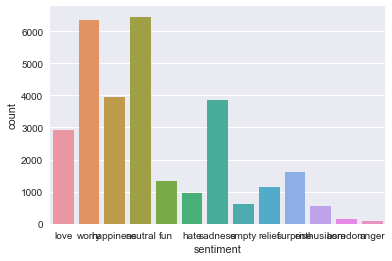

In [6]:
sns.countplot(df.sentiment)

In [7]:
df['sentiment'].value_counts('%')

neutral       0.215033
worry         0.211233
happiness     0.131733
sadness       0.128967
love          0.096933
surprise      0.053967
fun           0.044367
relief        0.038600
hate          0.032500
empty         0.020567
enthusiasm    0.018633
boredom       0.004500
anger         0.002967
Name: sentiment, dtype: float64

Se ven que los comentarios sin categoria o neutral se agrupan al 21%, por lo tanto presentara problemas de sesgo añadirlos a cualqueria de las 2 categorias objetivo, seran designadas de manera aleatoria simple para evitar este problema

# __Preliminares__

El objetivo de este proyecto es determinar si un tweet tiene connotacion positiva o negativa, mediante el aprendizaje de maquinas evaluaremos un tweet y generaremos una prediccion.  
Este tipo de problemas corresponden a problemas del tipo clasificacion, sus metricas principalmente rondaran en la matriz de confusion y su respectiva curva roc apoyandome tambien en los reportes de clasificacion y sus metricas de precision,recall y f1-score

In [8]:
import nltk 
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/feedingthemachine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/feedingthemachine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Para analizar las muestras las separaremos en un 80% de las muestras para entrenamiento y el 20% para testing

In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
df['content'] = df.content.apply(lambda x: lemmatizer.lemmatize(x))

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
# instanciamos un objeto
count_vectorizer=CountVectorizer(stop_words='english', max_features=5000)
# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(df.content)
# Extraemos tokens (palabras)
words = count_vectorizer.get_feature_names()
# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis=0)

df_words = pd.DataFrame({'Word':words, 'Frec':words_freq})

top5000 = df_words.sort_values(by='Frec', ascending=False)

In [12]:
top5000.head()

,Word,Frec
1176,day,2403
2363,just,2369
1867,good,1736
2561,like,1444
3519,quot,1399


<Figure size 288x288 with 0 Axes>

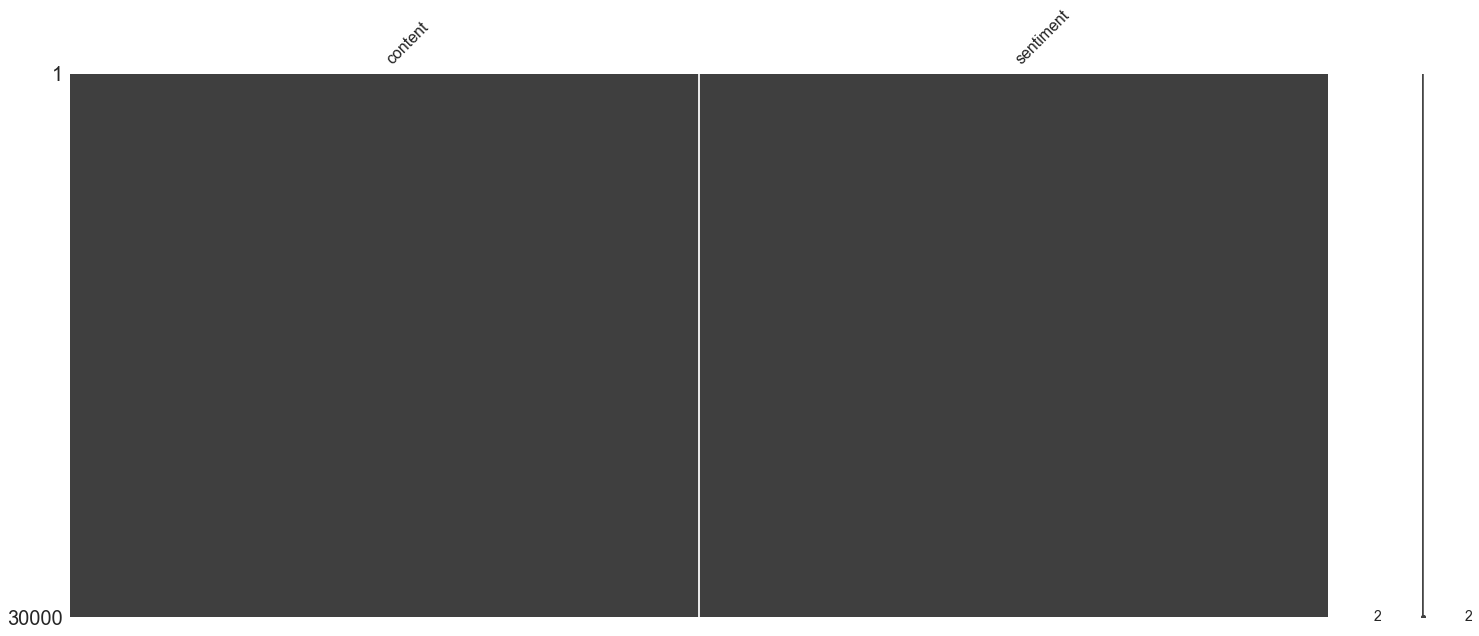

In [13]:
plt.figure(figsize=(4,4))
msngo.matrix(df);

In [14]:
isineutral = np.isin(df['sentiment'], ['neutral'])
isin = np.isin(df['sentiment'], ['happiness','love','surprise','fun','relief','enthusiasm','positive'])

In [15]:
df['sentiment'] = np.where(isineutral, np.random.choice(['positive', 'negative']),np.where(isin,'positive','negative'))

In [16]:
df['sentiment'] = np.where(df.sentiment == 'positive',1,0)

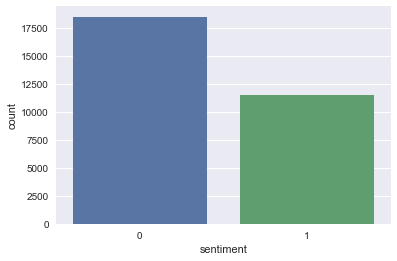

In [17]:
sns.countplot(df.sentiment)

Con el afan de aleatorizar los tweets neutrales explicado anteriormente, se realiza la aleatorizacion de la data.

In [18]:
df.sentiment.value_counts('%')

0    0.615767
1    0.384233
Name: sentiment, dtype: float64

Se verifica la tendencia del 60% en tweets de clasificados como negativos o clase 0

# __Análisis Exploratorio__

In [19]:
X_train , X_test , y_train , y_test = train_test_split(count_vectorizer_fit,df['sentiment'], test_size=.20 , random_state=633)

In [20]:
def roc_graphic(y_test, y_hat):
    from sklearn.metrics import roc_curve
    false_positive , true_positive , threshold = roc_curve(y_test,y_hat[:,1])
    plt.plot(false_positive,true_positive,lw = 1)
    plt.plot([0,1], linestyle='--', lw=1, color='tomato')
    plt.ylabel('Verdaderos Positivos')
    plt.xlabel('Falsos Positivos')

In [21]:
pipeline_model = Pipeline([('count_vectorize', CountVectorizer()), ('modelo', MultinomialNB())])
#modelo = pipeline_model.fit(X_train, y_train)

In [22]:
gs_naives = GridSearchCV(MultinomialNB(),
                         {'alpha':np.linspace(0.1,1.0,10), 
                          'fit_prior':[True,False], 
                          'class_prior':[None]},cv=5).fit(X_train, y_train)

In [23]:
pickle.dump(gs_naives, open('naives_bayes.sav','wb'))

In [24]:
gs_pred = gs_naives.predict(X_test)
gs_pred_proba = gs_naives.predict_proba(X_test)

In [25]:
print(classification_report(y_test, gs_pred))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      3651
           1       0.65      0.57      0.61      2349

    accuracy                           0.71      6000
   macro avg       0.70      0.69      0.69      6000
weighted avg       0.71      0.71      0.71      6000



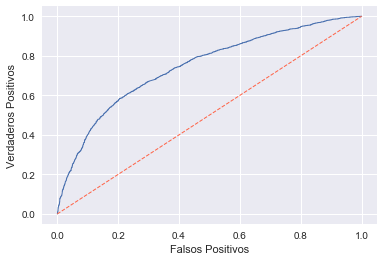

In [26]:
roc_graphic(y_test,gs_pred_proba)

In [27]:
dec_tree_grid_cv = GridSearchCV(DecisionTreeClassifier(),
                               {'min_samples_split': np.linspace(0.1,1.0,10),
                               'criterion':['gini','entropy'],
                               'max_depth': np.linspace(1,32,32),
                               'min_samples_leaf': np.linspace(0.1,0.5,10),
                               },cv=5).fit(X_train, y_train)

In [28]:
pickle.dump(dec_tree_grid_cv, open('decision_tree_model.sav','wb'))

In [29]:
dt_pred = dec_tree_grid_cv.predict(X_test)
dt_pred_proba = dec_tree_grid_cv.predict_proba(X_test)

In [ ]:
print(classification_report(y_test, dt_pred))

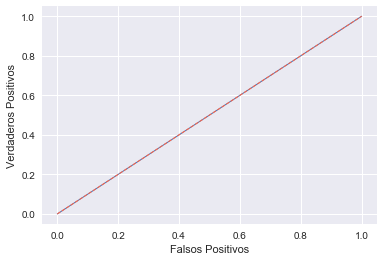

In [30]:
roc_graphic(y_test,dt_pred_proba)

In [31]:
rf_cv = GridSearchCV(RandomForestClassifier(),{
                                    'n_estimators': [4, 6, 9], 
                                    'max_features': ['log2', 'sqrt','auto'], 
                                    'criterion': ['entropy', 'gini'],
                                    'max_depth': [2, 3, 5, 10], 
                                    'min_samples_split': [2, 3, 5],
                                    'min_samples_leaf': [1,5,8]
                                     },cv=5).fit(X_train, y_train)

In [32]:
pickle.dump(rf_cv, open('random_forest.sav','wb'))

In [33]:
rf = rf_cv.predict(X_test)
rf_pred_proba = rf_cv.predict_proba(X_test)

In [34]:
print(classification_report(y_test, rf))

              precision    recall  f1-score   support

           0       0.63      0.98      0.77      3651
           1       0.77      0.10      0.17      2349

    accuracy                           0.64      6000
   macro avg       0.70      0.54      0.47      6000
weighted avg       0.68      0.64      0.53      6000



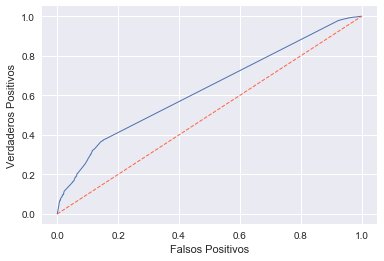

In [35]:
roc_graphic(y_test,rf_pred_proba)

In [ ]:
ld_cv = GridSearchCV(LinearDiscriminantAnalysis(),{
                        'n_components':np.linspace(1,4,4,dtype=int), 
                        #'solver':['svd','lsqr','eigen'], 
                        }).fit(X_train.toarray(),y_train)

In [ ]:
pickle.dump(cv_lda_model, open('latent.sav','wb'))

In [38]:
ld = ld_cv.predict(X_test)
ld_pred_proba = ld_cv.predict_proba(X_test)

In [50]:
print(classification_report(y_test, best_lda))

TypeError: Expected sequence or array-like, got estimator LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=1, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [49]:
roc_graphic(y_test,ld_pred_proba)

NameError: name 'ld_pred_proba' is not defined

In [ ]:
c_param_range= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma_param_range = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': c_param_range, 'gamma' : gamma_param_range}

In [ ]:
svc_cv = GridSearchCV(SVC(kernel='rbf'),param_grid,cv = 10).fit(X_train, y_train)

In [ ]:
pickle.dump(svc_cv, open('svc.sav','wb'))

In [ ]:
svc = svc_cv.predict(X_test)
svc_pred_proba = svc_cv.predict_proba(X_test)

In [ ]:
print(classification_report(y_test, svc))

In [ ]:
roc_graphic(y_test,svc_pred_proba)

Se adjuntan las grillas propuestas para los diversos modelos de evaluacion para el problema establecido